In [2]:
%load_ext autoreload
%autoreload 2

# Human Melanoma (SlideTags)

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
# from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

import celloracle as co

In [4]:
%matplotlib inline

In [17]:
data_dir = '/Users/koush/Downloads/SlideTagsMelanoma/SCP2171'
adata = sc.read_csv(f'{data_dir}/expression/HumanMelanomaRNA_expression.csv.gz').T
spatial_df = pd.read_csv(f'{data_dir}/cluster/HumanMelanomaRNA_spatial.csv')
adata.obs = adata.obs.join(spatial_df.set_index('NAME'))
adata.obsm['spatial'] = adata.obs[['X', 'Y']].values.astype(np.float64)

... storing 'X' as categorical
... storing 'Y' as categorical
... storing 'cell_type' as categorical


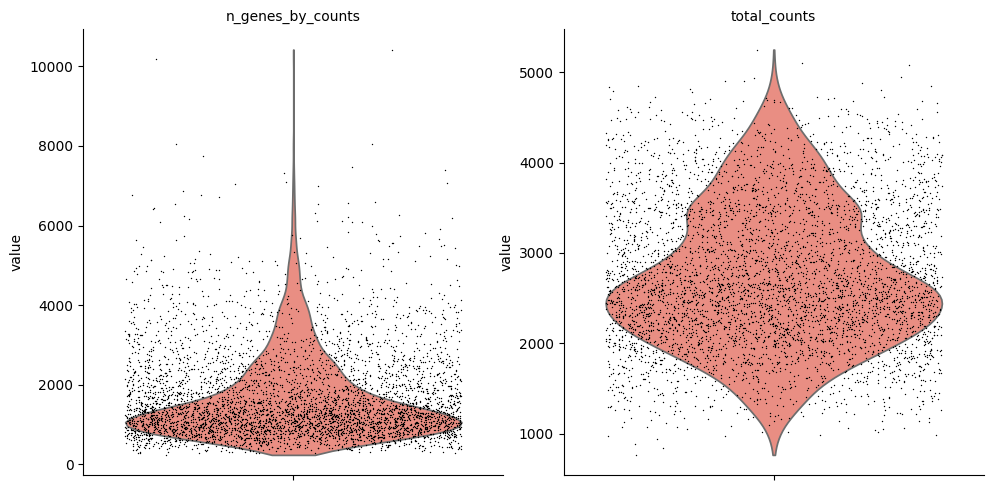

In [25]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts'],
    jitter=0.4,
    multi_panel=True,
    color='salmon',
)

In [27]:
adata.var_names

Index(['OR4F5', 'AL627309.1', 'AL627309.5', 'AL627309.4', 'AL669831.2',
       'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C',
       ...
       'BX004987.1', 'MAFIP', 'AC011043.1', 'AL354822.1', 'AL592183.1',
       'AC240274.1', 'AC004556.3', 'AC233755.2', 'AC233755.1', 'AC007325.4'],
      dtype='object', length=25066)

In [28]:
base_GRN = co.data.load_human_promoter_base_GRN()

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

extra_genes = np.unique(['FOXO1', 'BATF', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 'ID2', 'PAX5', 
    'CXCR4', 'CD83', 'CD86', 'AICDA', 'BCL2A1', 'BCL2', 'LMO2', 'CXCL13', 
    'CD80', 'TRAF3', 'CCL19', 'CCR7', 'CCL21', 'CD40LG', 'CD40', 'IRF4', 'IRF8', 
    'ITGA5', 'ITGB1', 'ITGAM', 'ITGB2', 'CCR6', 'CD19', 'LGALS9',
    'BCL2', 'IL2', 'IL4', 'CD83', 'CD86', 'SDF4', 'SDF2', 'SDF2L1', 
    'S1PR1', 'BMS1P14', 'S1PR3', 'S1PR4', 'S1PR2', 'EBI3', 'CD28', 
    'MICOS10', 'ICOS', 'MICOS13', 'ICOSLG', 'PDCD11', 'PDCD1', 'CD274', 
    'PDCD1LG2', 'TICAM2', 'ICAM2', 'TICAM1', 'EPCAM', 'ICAM1', 'ICAM3', 
    'VCAM1', 'CXCR4', 'CXCR5',  'CXCL13', 'CXCL14', 'CXCL12', 'CR2', 'NFKBIZ', 
    'NFKB1', 'NFKBIL1', 'NFKBIE', 'NFKB2', 'NFKBIA', 'NFKBID', 'NFKBIB', 
    'IL6R', 'IL6ST', 'EGR1', 'EGR3', 'EGR2', 'GATA3', 'TBX21', 'STAT3', 
    'STAT1', 'STAT4', 'STAT6', 'IL4', 'IL6ST', 'IL6', 'IL17A', 'CCR4', 'CCL5'])

len(extra_genes)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


87

In [29]:
adata = adata[:, ~adata.var_names.str.contains('RIK')]
adata = adata[:, ~adata.var_names.str.contains(r'^HB\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('HP')]
adata = adata[:, ~adata.var_names.str.startswith('RP')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('GM')]
adata = adata[:, ~adata.var_names.str.startswith('MIR')]
adata = adata[:, ~adata.var_names.str.startswith('TTT')]
adata = adata[:, ~adata.var_names.str.startswith('LINC')]
adata = adata[:, ~adata.var_names.str.endswith('-AS1')]

In [30]:
n_top_genes = 3500
min_cells = 10
min_counts = 50

In [31]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 10].copy()
adata = adata[:, ~adata.var["MT"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["normalized_count"] = adata.to_df().values.copy()

ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(list(extra_genes)+lr_df.query(
    'expr > 0.005').genes.to_list()))]

adata

View of AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'MT', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [32]:
for key in ['n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['MT', 'RP', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [35]:
adata.obs['author_cell_type'] = adata.obs['cell_type'].copy()

In [36]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [37]:
adata

AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'normalized_count'

In [38]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

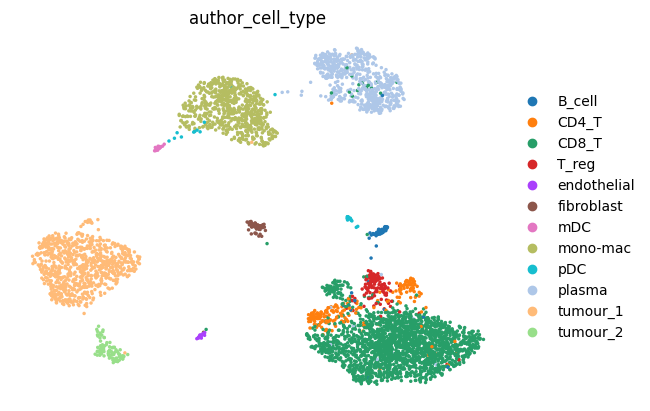

In [ ]:
sc.pl.umap(adata, color='author_cell_type', frameon=False, linewidth=0.1)

In [47]:
BaseTravLR.impute_clusterwise(adata)

In [48]:
adata

AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'pca', 'neighbors', 'umap', 'author_cell_type_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized_count', 'imputed_count'
    obsp: 'distances', 'connectivities'

In [52]:
adata.obs.cell_type.value_counts().index

CategoricalIndex(['CD8_T', 'tumour_1', 'mono-mac', 'plasma', 'CD4_T', 'T_reg',
                  'tumour_2', 'B_cell', 'fibroblast', 'pDC', 'mDC',
                  'endothelial'],
                 categories=['B_cell', 'CD4_T', 'CD8_T', 'T_reg', ..., 'pDC', 'plasma', 'tumour_1', 'tumour_2'], ordered=False, dtype='category', name='cell_type')

In [66]:
adata.obs.cell_type = adata.obs.author_cell_type.copy()

In [67]:
adata.obs.cell_type = adata.obs.cell_type.astype('str')
adata.obs.cell_type = adata.obs.cell_type.replace(
    {
        'CD8_T': 'CD8+ T', 
        'tumour_1': 'Tumor 1',
        'mono-mac': 'Mono-mac',
        'plasma': 'Plasma/B',
        'CD4_T': 'CD4+ T',
        'T_reg': 'Treg',
        'tumour_2': 'Tumor 2',
        'B_cell': 'Plasma/B',
        'fibroblast': 'Other',
        'pDC': 'Other',
        'mDC': 'Other',
        'endothelial': 'Other'
    }
)

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [68]:
adata.obs.cell_type.value_counts()

cell_type
CD8+ T      2119
Tumor 1      812
Mono-mac     692
Plasma/B     654
CD4+ T       198
Treg         123
Other        119
Tumor 2       87
Name: count, dtype: int64

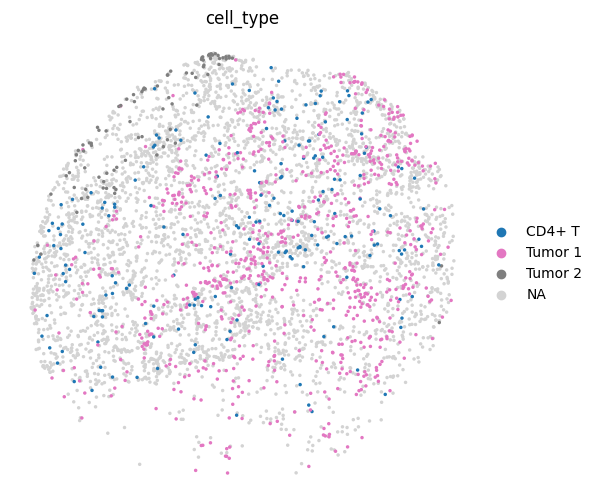

In [76]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100

sc.pl.embedding(adata, basis='spatial', color=['cell_type'], 
    frameon=False, groups=['Tumor 1', 'Tumor 2', 'CD4+ T'])

In [77]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_melanoma.h5ad')

In [78]:
adata.obs.cell_type.value_counts()

cell_type
CD8+ T      2119
Tumor 1      812
Mono-mac     692
Plasma/B     654
CD4+ T       198
Treg         123
Other        119
Tumor 2       87
Name: count, dtype: int64

In [79]:
adata.obs.author_cell_type.value_counts()

author_cell_type
CD8_T          2119
tumour_1        812
mono-mac        692
plasma          602
CD4_T           198
T_reg           123
tumour_2         87
B_cell           52
fibroblast       50
pDC              26
mDC              25
endothelial      18
Name: count, dtype: int64